In [1]:
import networkx as nx

import numpy as np
import torch
from tqdm import tqdm

from rostok.graph_grammar.node import GraphGrammar
from rostok.graph_grammar.node_vocabulary import NodeVocabulary
from rostok.graph_grammar.rule_vocabulary import RuleVocabulary
import rule_without_chrono as re


c:\Programs\mambaforge\envs\pytorch_pychrono\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:

def get_input_layer(node, dict_id_label_nodes):
    input = torch.zeros(len(dict_id_label_nodes)).long()
    input[node] = 1
    return input

def vocabulary2batch_graph(rule_vocabulary: RuleVocabulary, max_rules: int):

    batch_graph = GraphGrammar()
    amount_rules = np.random.randint(1, max_rules)
    for _ in range(amount_rules):
        rules = rule_vocabulary.get_list_of_applicable_rules(batch_graph)
        if len(rules) > 0:
            rule = rule_vocabulary.get_rule(rules[np.random.choice(len(rules))])
            batch_graph.apply_rule(rule)
        else:
            break
    return batch_graph

def random_batch(skip_grams):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), 1, replace=False)

    for i in random_index:
        random_inputs.append(skip_grams[i][0])  # target
        random_labels.append(skip_grams[i][1])  # context word

    return random_inputs, random_labels


In [50]:

class skipgramm_model(torch.nn.Module):

    def __init__(self, vocabulary_size: int, embedding_size: int):
        super().__init__()

        self.embedding = torch.nn.Embedding(vocabulary_size, embedding_size)
        self.W = torch.nn.Linear(embedding_size, embedding_size, bias=False)
        self.WT = torch.nn.Linear(embedding_size, vocabulary_size, bias=False)

    def forward(self, x):
        embdedings = self.embedding(x)
        hidden_layer = torch.nn.functional.relu(self.W(embdedings))
        output_layer = self.WT(hidden_layer)
        out = torch.nn.functional.log_softmax(self.WT(hidden_layer))

        return out

    def get_node_embedding(self, node, sorted_node_labels, dict_label_id_nodes):
        input = torch.zeros(len(sorted_node_labels)).long()
        input[dict_label_id_nodes[node]] = 1
        return self.embedding(input).view(1, -1)


def skipgram(paths, dict_label_id_nodes, window_size=1):
    idx_pairs = []
    for path in paths:
        indices = [dict_label_id_nodes[node_label] for node_label in path]
        for pos_center_node, node_index in enumerate(indices):
            for i in range(-window_size, window_size + 1):
                pos_context_node = pos_center_node + i

                if pos_context_node < 0 or pos_context_node >= len(
                        indices) or pos_center_node == pos_context_node:
                    continue
                context_id_node = indices[pos_context_node]
                idx_pairs.append((node_index, context_id_node))

    return np.array(idx_pairs)

def skipgram_2ver(paths, dict_label_id_nodes, window_size=1):
    idx_pairs = []
    nodes = []
    for path in paths:
        nodes += path
    indices = [dict_label_id_nodes[node_label] for node_label in nodes]
    for pos_center_node, node_index in enumerate(indices):
        for i in range(-window_size, window_size + 1):
            pos_context_node = pos_center_node + i

            if pos_context_node < 0 or pos_context_node >= len(
                    indices) or pos_center_node == pos_context_node:
                continue
            context_id_node = indices[pos_context_node]
            idx_pairs.append((node_index, context_id_node))

    return np.array(idx_pairs)

def create_dict_node_labels(node_vocabulary: NodeVocabulary):

    sorted_node_labels = sorted(node_vocabulary.node_dict.keys())

    dict_id_label_nodes = dict(enumerate(sorted_node_labels))
    dict_label_id_nodes = {w: idx for (idx, w) in enumerate(sorted_node_labels)}

    return dict_id_label_nodes, dict_label_id_nodes


In [49]:
rule_vocab = re.init_extension_rules()
node_vocabulary = rule_vocab.node_vocab

id2label, label2id = create_dict_node_labels(node_vocabulary)
data = []
for __ in range(10000):
    graph = vocabulary2batch_graph(rule_vocab, 15)
    pairs = skipgram_2ver(graph.get_uniq_representation(),label2id)
    for pair in pairs:
        data.append(pair)
data = np.array(data)

In [ ]:
node_vocabulary.node_dict

In [51]:
list_losses = []

In [52]:
model = skipgramm_model(len(id2label), 2)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
for epoch in tqdm(range(5000)):
    input_batch, target_batch = random_batch(data)
    input_batch = get_input_layer(input_batch, id2label)
    target_batch = get_input_layer(target_batch, id2label)

    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    list_losses.append(loss)
    if (epoch + 1) % 10000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), ' cost =', '{:.6f}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\krake\AppData\Local\Temp\ipykernel_16524\3441750880.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(self.WT(hidden_layer))
100%|██████████| 5000/5000 [02:28<00:00, 33.76it/s]


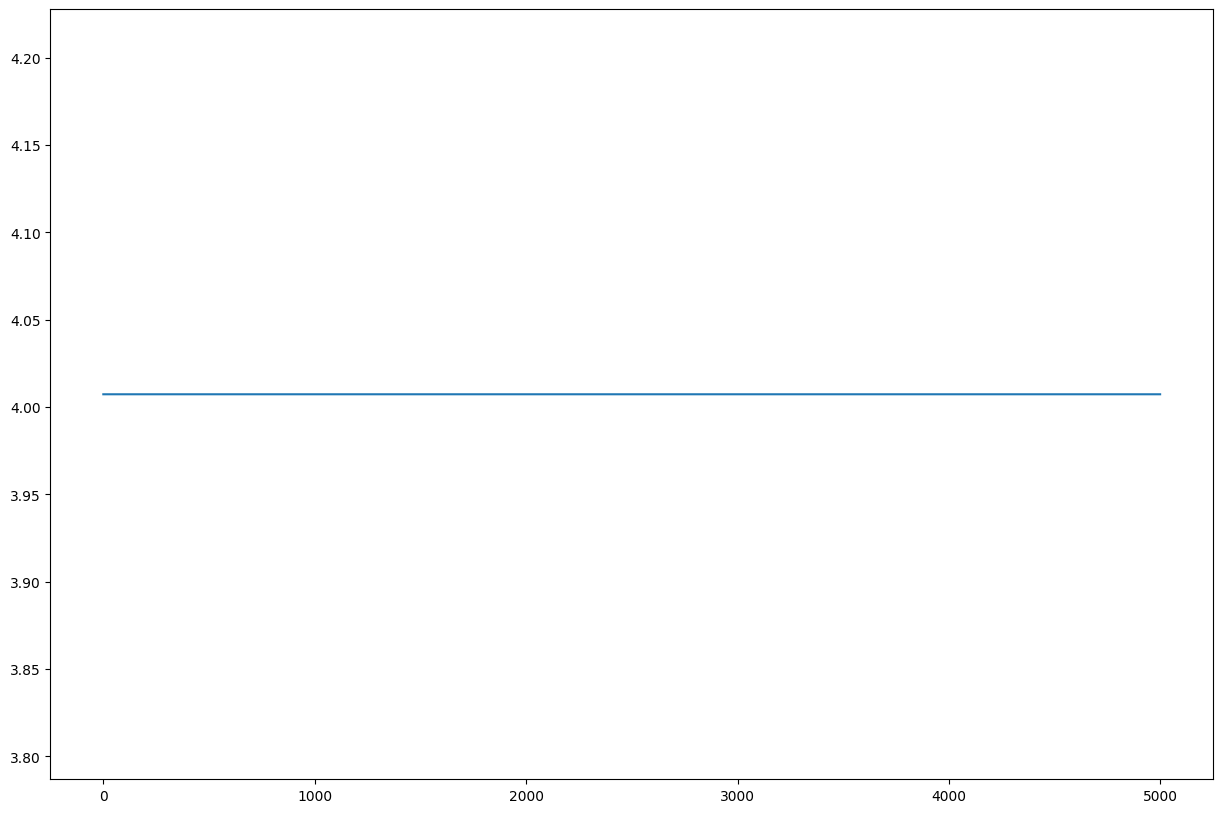

In [53]:
import matplotlib.pyplot as plt
list_losses = list(map(lambda x: x.detach().numpy(), list_losses))
plt.figure(figsize=(15,10))
plt.plot(range(len(list_losses)),list_losses)
plt.show()

In [54]:
def Skipgram_test(test_data, model):
    correct_ct = 0

    for i in range(len(test_data)):
        input_batch, target_batch = random_batch(test_data)
        input_batch = get_input_layer(input_batch, id2label)
        target_batch = get_input_layer(target_batch, id2label)

        model.zero_grad()
        _, predicted = torch.max(model(input_batch), 1)

        if predicted == target_batch:
                correct_ct += 1

    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

In [55]:
Skipgram_test(skipgram(graph.get_uniq_representation(), label2id), model)

C:\Users\krake\AppData\Local\Temp\ipykernel_16524\3441750880.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(self.WT(hidden_layer))


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

-0.25469777 0.9867691
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.049641125 1.890662
-0.0496411

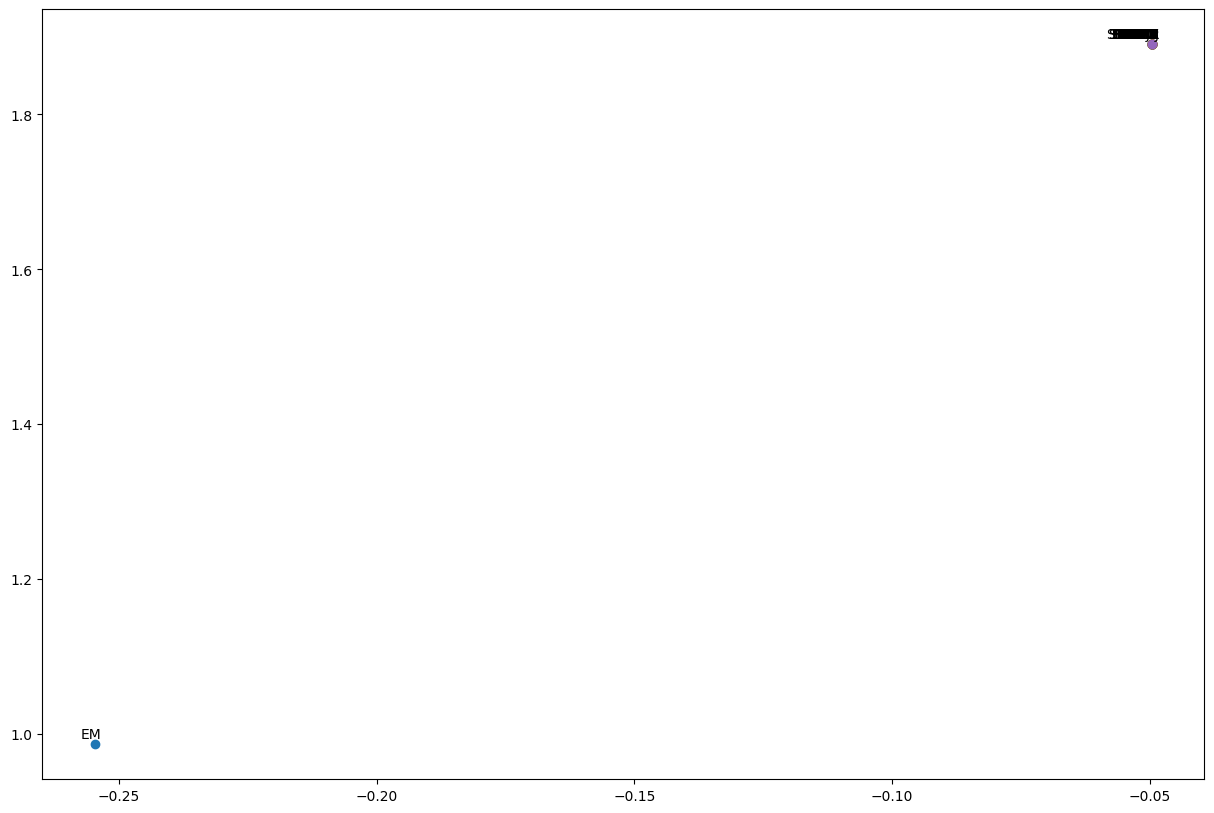

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
for w in label2id.keys():
    x = model.get_node_embedding(w, label2id.keys(), label2id).detach().data.numpy()[0][0]
    y = model.get_node_embedding(w, label2id.keys(), label2id).detach().data.numpy()[0][1]
    plt.scatter(x, y)
    print(x,y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

In [ ]:
print(pairs, label2id)

In [ ]:
graph.get_uniq_representation()